### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

# Dynamic Routing Pattern:
Routing decisions are often dynamic, based on real-time analysis of input data, task requirements, or resource availability. For Example:
A prompt involving natural language query against a system of record might be routed to a specialized NL2SQL agent instead of a general-purpose LLM.
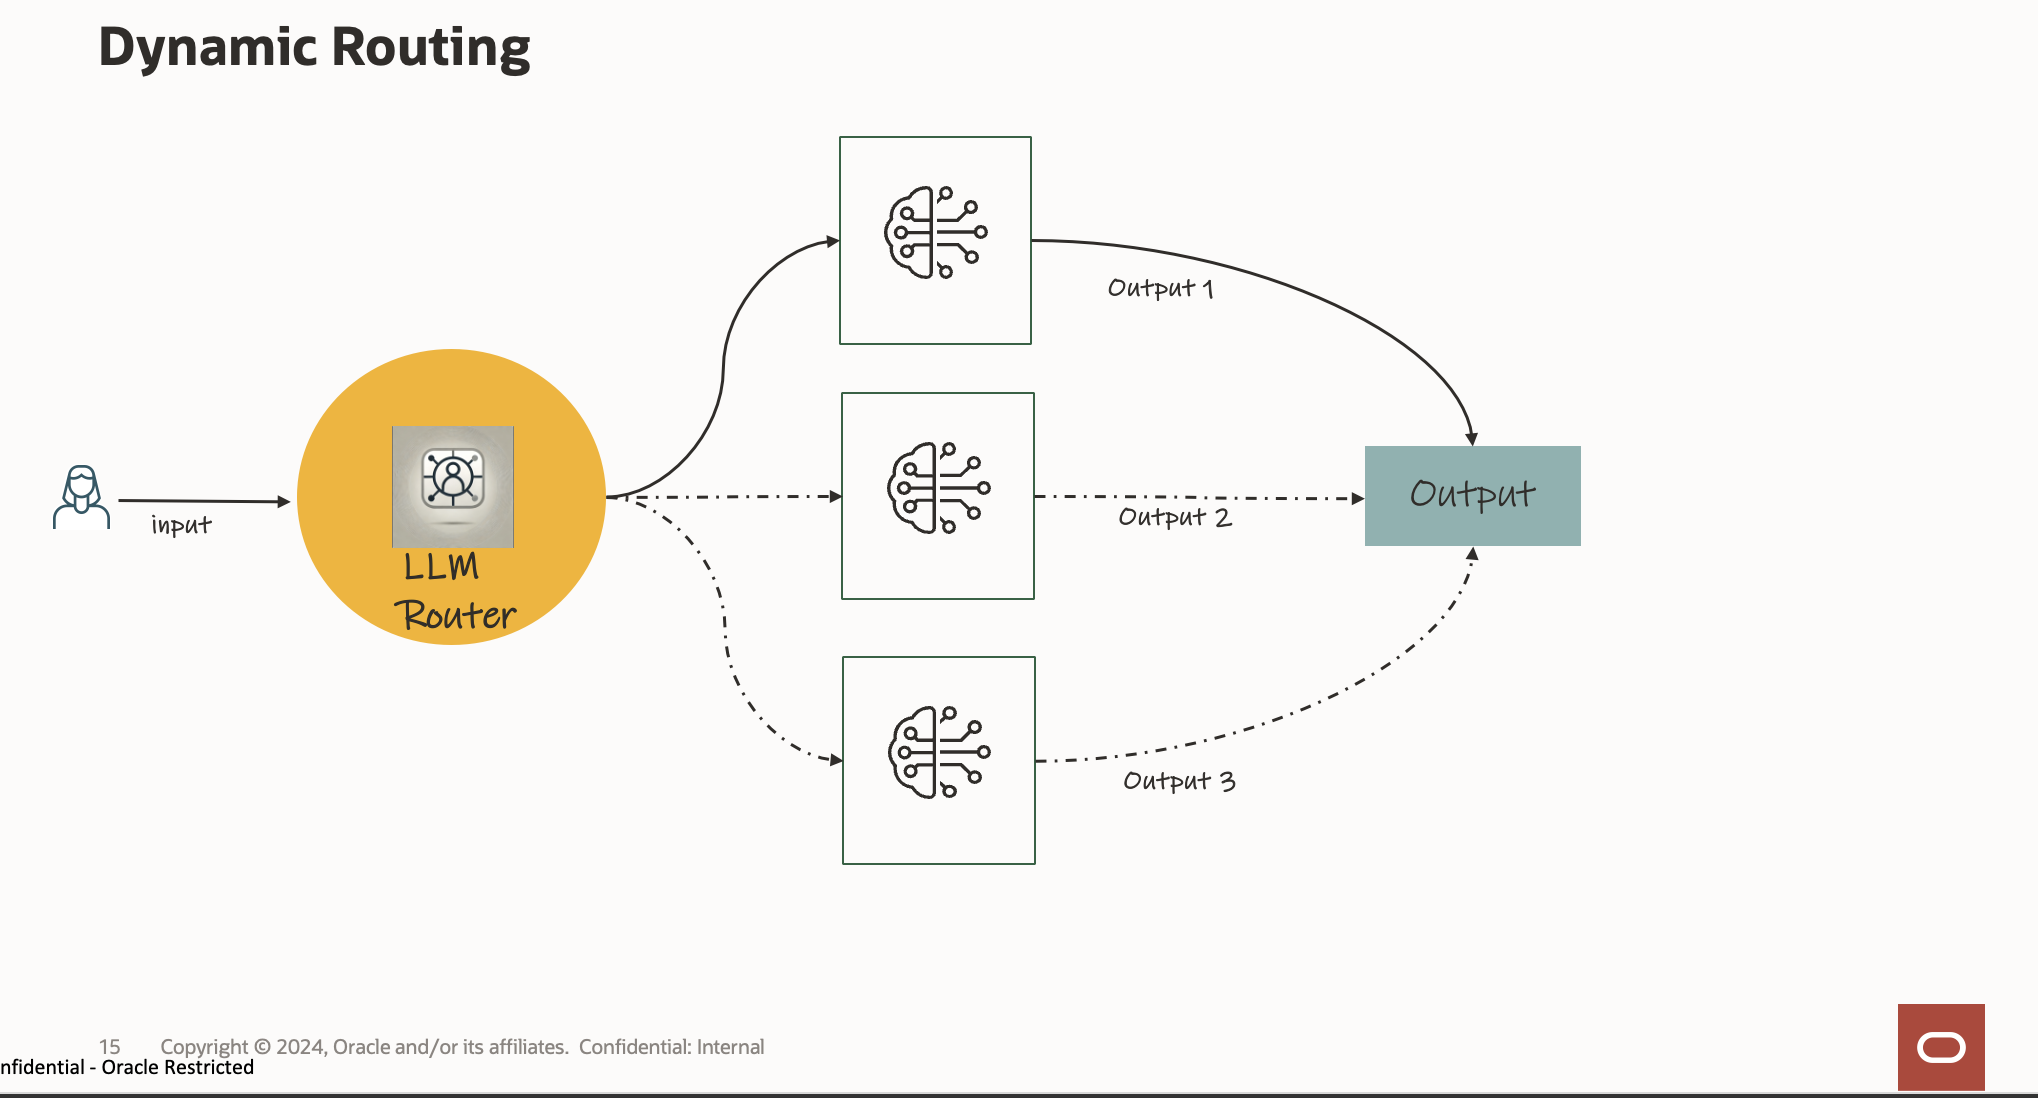

# Environment

In [26]:
! pip install --quiet langchain langchain_cohere langchain-openai tiktoken langchainhub chromadb langgraph

# LLM

In [27]:
from langchain_community.chat_models.oci_generative_ai import ChatOCIGenAI
from langchain.prompts import PromptTemplate  # For creating prompts 


# Set your OCI credentials 
compartment_id = "ocid1.compartment.oc1..aaaaaaaau6esoygdsqxfz6iv3u7ghvosfskyvd6kroucemvyr5wzzjcw6aaa" 
service_endpoint = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com" 
#model_id = "meta.llama-3.3-70b-instruct"
model_id = "cohere.command-r-plus-08-2024"
# Create an OCI Cohere LLM instance 
llm = ChatOCIGenAI(
    model_id= model_id,  # Specify the model you want to use 
    service_endpoint=service_endpoint,
    compartment_id=compartment_id,
    model_kwargs={"temperature": 0.7, "top_p": 0.75, "max_tokens": 1000}
) 



In [45]:
# ### Tracing (optional)
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"
os.environ["USER_AGENT"] = "MyCustomUserAgent/1.0"
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

# Embedding

In [29]:
from langchain_community.embeddings import OCIGenAIEmbeddings
# Embedding Service endpoint
endpoint = "https://inference.generativeai.us-chicago-1.oci.oraclecloud.com"

embeddings = OCIGenAIEmbeddings(
  model_id="cohere.embed-english-v3.0",
  service_endpoint=endpoint,
  truncate="NONE",
  compartment_id=compartment_id
)


In [30]:
## TEST CASE 

documents = ["hi, my name is anup"]
response = embeddings.embed_documents(documents)
#print (response)

# Tools
We use a router to pick between tools.

Cohere model decides which tool(s) to call, as well as the how to query them.

### Router

In [31]:
### Router

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

# Data model
class web_search(BaseModel):
    """
    The internet. Use web_search for questions that are related to anything else than agents, prompt engineering, and adversarial attacks.
    """

    query: str = Field(description="The query to use when searching the internet.")


class vectorstore(BaseModel):
    """
    A vectorstore containing documents related to agents, prompt engineering, and adversarial attacks. Use the vectorstore for questions on these topics.
    """

    query: str = Field(description="The query to use when searching the vectorstore.")


# Preamble
preamble = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""

# LLM with tool use and preamble

structured_llm_router = llm.bind_tools(
    tools=[web_search, vectorstore], #preamble=preamble
)

# Prompt
# Define the chat prompt template
        
route_prompt = ChatPromptTemplate.from_messages([
    SystemMessage(content=preamble),  # System message
    ("human", "{question}")  # Corrected human message syntax
])


question_router = route_prompt | structured_llm_router



In [32]:
## TEST CASES ###

response = question_router.invoke(
    {"question": "What are the key characteristics of OCI"}
)
print(response.response_metadata["tool_calls"])


response = question_router.invoke({"question": "What are the types of agent memory?"})
print(response.response_metadata["tool_calls"])


response = question_router.invoke({"question": "Hi how are you?"})
print("tool_calls" in response.response_metadata)

[{'id': '79235f2c146a4307bb6880ce4eef012f', 'function': {'name': 'web_search', 'arguments': '{"query": "OCI characteristics"}'}, 'type': 'function'}]
[{'id': 'f1f29f2dd27a417b8e59619ce1274448', 'function': {'name': 'vectorstore', 'arguments': '{"query": "types of agent memory"}'}, 'type': 'function'}]
False


### Web Search Tool

In [33]:
### Search
import os
os.environ['TAVILY_API_KEY'] ='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'

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults()

### RAG Tool

In [34]:
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
#from langchain_cohere import CohereEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=512, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)


# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    embedding=embeddings,
)

retriever_vector = vectorstore.as_retriever()

print(retriever_vector)

tags=['Chroma', 'OCIGenAIEmbeddings'] vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f20ed831990> search_kwargs={}


# Master Node - Generate

In [35]:
### Generate

from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser

# Preamble
preamble = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise."""

# Prompt
def prompt(x):
    return ChatPromptTemplate.from_messages(
        [
            SystemMessage(content=preamble),
            HumanMessage(
                f"Question: {x['question']} \nAnswer: ",
                additional_kwargs={"documents": x["documents"]},
            )
        ]
    )

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [36]:
## TEST CASES ###
# Run
question = "What are the types of agent memory?"
generation = rag_chain.invoke({"documents": docs, "question": question})
print(generation)

Declarative, procedural, semantic, and episodic. These types of memory are involved in various cognitive processes, allowing agents to store and retrieve information for decision-making and problem-solving. Each type has distinct characteristics and functions, contributing to an agent's overall knowledge and behavior.


### LLM fallback Node

In [37]:
### LLM fallback
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage
from langchain_core.output_parsers import StrOutputParser

# Preamble
preamble = """You are an assistant for question-answering tasks. Answer the question based upon your knowledge. Use facts while answering. Use three sentences maximum and keep the answer concise."""

# Prompt

def prompt(x):
    return ChatPromptTemplate.from_messages(
        [
            SystemMessage(content=preamble),
            HumanMessage(f"Question: {x['question']} \nAnswer: ")
        ]
    )

# Chain
llm_chain = prompt | llm | StrOutputParser()

In [38]:
## TEST CASES ###
# Run
question = "What are the key characteristics of OCI?"
generation = llm_chain.invoke({"question": question})
print(generation)

question = "Hi, my name is Anup. Can you rember it?"
generation = llm_chain.invoke({"question": question})
print(generation)

question = "What are the types of agent memory?"
generation = llm_chain.invoke({"documents": docs, "question": question})
print(generation)

OCI, or Oracle Cloud Infrastructure, is a cloud computing service offering high-performance computing, storage, and networking resources. It provides scalability, security, and cost-efficiency with features like automated infrastructure, data encryption, and a pay-as-you-go model. OCI is known for its robust architecture, allowing businesses to build and manage various applications and workloads.
Hello Anup! I have made a note of your name. I can remember this information for future interactions. Is there anything else I can help you with?
Agent memory can be categorized into three types: episodic, semantic, and procedural. Episodic memory stores personal experiences and events, while semantic memory retains general facts and knowledge. Procedural memory involves learning and remembering how to perform tasks and skills.


# Graph
Capture the flow in as a graph.

# Graph state

In [39]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """|
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

# Graph Flow

In [40]:
from langchain.schema import Document

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    
    generation = llm_chain.invoke({"documents": web_results, "question": question})
    
    
    return {"documents": web_results, "question": question, "generation": generation}

def retrieve_vector(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever_vector.invoke(question)
    return {"documents": documents, "question": question}


def rag(state):
    """
    Generate answer using the vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---RAG---")
    question = state["question"]
    documents = state["documents"]
    if not isinstance(documents, list):
        documents = [documents]

    # RAG 
    rag = rag_chain.invoke({"documents": documents, "question": question})
    #print("rag : " + str(rag))
    return {"documents": documents, "question": question, "generation": rag}


def llm_fallback(state):
    """
    Generate answer using the LLM w/o vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---LLM Fallback---")
    question = state["question"]
    generation = llm_chain.invoke({"question": question})
    #print("llm_fallback generation : " + str(generation))
    return {"question": question, "generation": generation}

def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})

    # Fallback to LLM or raise error if no decision
    if "tool_calls" not in source.additional_kwargs:
        print("---ROUTE QUESTION TO LLM---")
        return "llm_fallback"
    if len(source.additional_kwargs["tool_calls"]) == 0:
        raise "Router could not decide source"

    # Choose datasource
    datasource = source.additional_kwargs["tool_calls"][0]["function"]["name"]
    if datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
    else:
        print("---ROUTE QUESTION TO LLM---")
        return "vectorstore"


# Build Graph

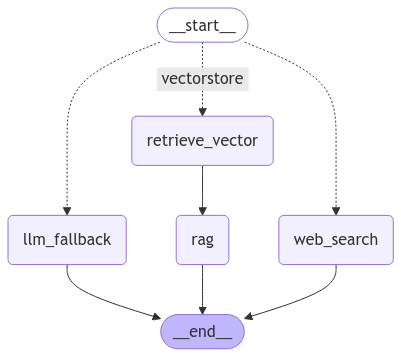

In [41]:
import pprint
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve_vector", retrieve_vector)  # retrieve_vector
workflow.add_node("rag", rag)  # rag
workflow.add_node("llm_fallback", llm_fallback)  # llm

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve_vector",
        "llm_fallback": "llm_fallback",
    },
)
workflow.add_edge("retrieve_vector", "rag")
workflow.add_edge("web_search", END)
workflow.add_edge("rag", END)
workflow.add_edge("llm_fallback", END)

# Compile
app = workflow.compile()

# View
display(Image(app.get_graph(xray=1).draw_mermaid_png()))

In [42]:
# Run
inputs = {
    "question": "Where and when is the next Soccer Worldcup?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        #pprint.pprint(f"Node '{value}':")
        # Optional: print full state at each node
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
"Node 'web_search':"
'\n---\n'
('The 2026 FIFA World Cup will be the 23rd edition of the FIFA World Cup, the '
 "quadrennial international men's football championship contested by the "
 'national teams of the member associations of FIFA. It is scheduled to take '
 'place in the United States, Canada, and Mexico from June 11 to July 11, '
 '2026. This will be the first World Cup in history to be hosted by three '
 'countries.')


In [43]:
# Run
inputs = {
    "question": "Hi, my name is Anup. Can you rember it?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO LLM---
---LLM Fallback---
"Node 'llm_fallback':"
'\n---\n'
('Hello Anup! I have noted your name and will remember it for future '
 'interactions. I am designed to store and retrieve information, ensuring a '
 'personalized experience. Please let me know if there is anything else I can '
 'assist you with.')


In [44]:
# Run
inputs = {
    "question": "What are the types of agent memory?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint.pprint(f"Node '{key}':")
        # Optional: print full state at each node
    pprint.pprint("\n---\n")

# Final generation
pprint.pprint(value["generation"])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
"Node 'retrieve_vector':"
'\n---\n'
---RAG---
"Node 'rag':"
'\n---\n'
('There are two main types of memory in an agent system: long-term memory and '
 'short-term memory. Long-term memory stores information that is relevant over '
 'an extended period, while short-term memory holds temporary data for quick '
 "access and decision-making. These memory types are crucial for an agent's "
 'ability to learn, adapt, and perform tasks efficiently.')
